# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
!wget  'https://jb-course-utils.s3.amazonaws.com/advanced-machine-learning/computer-vision/face-recognition-task.zip' -O 'face-recognition-task.zip'

--2018-10-31 17:31:00--  https://jb-course-utils.s3.amazonaws.com/advanced-machine-learning/computer-vision/face-recognition-task.zip
Resolving jb-course-utils.s3.amazonaws.com (jb-course-utils.s3.amazonaws.com)... 52.218.200.178
Connecting to jb-course-utils.s3.amazonaws.com (jb-course-utils.s3.amazonaws.com)|52.218.200.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021224017 (974M) [application/zip]
Saving to: ‘face-recognition-task.zip’

face-recognition-ta 100%[===================>] 973.92M  21.8MB/s    in 57s     

2018-10-31 17:31:58 (17.2 MB/s) - ‘face-recognition-task.zip’ saved [1021224017/1021224017]



In [2]:
!unzip *zip

Archive:  face-recognition-task.zip
   creating: face-recognition-task/
  inflating: face-recognition-task/get_data.py  
  inflating: face-recognition-task/face_recognition_model.h5  
 extracting: face-recognition-task/Face_Recognition_data.zip  
  inflating: face-recognition-task/Face Recognition task.ipynb  


In [0]:
!mv face-recognition-task/get_data.py .
!mv face-recognition-task/Face_Recognition_data.zip .
!mv face-recognition-task/face_recognition_model.h5 .

In [4]:
import pandas as pd
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [5]:
%pylab inline
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Run the cell below to unpack data.

In [0]:
from get_data import unpack
unpack('Face_Recognition_data.zip')

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [7]:
!ls Face_Recognition_data/image_classification/train

images	y_train.csv


In [8]:
!head Face_Recognition_data/image_classification/train

head: error reading 'Face_Recognition_data/image_classification/train': Is a directory


In [0]:
def load_images_split(dir_name, split):
      y_series = pd.read_csv(os.path.join(dir_name, split, 'y_{}.csv'.format(split)))
      image_dict = {path: cv2.imread(os.path.join(dir_name, split, 'images', path)) for (_, (path, name)) in y_series.iterrows()}
      names_dict = {path: name for (_, (path, name)) in y_series.iterrows()}
      return image_dict, names_dict

def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):    
    return load_images_split(dir_name, 'train'), load_images_split(dir_name, 'test')

In [10]:
(x_train, y_train), (x_test, y_test) = load_image_data()
print '%d'%len(x_train), '\ttraining images'
print '%d'%len(x_test), '\ttesting images'

661 	training images
808 	testing images


In [0]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(data.keys(), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

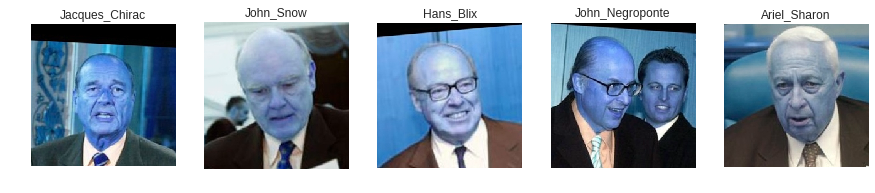

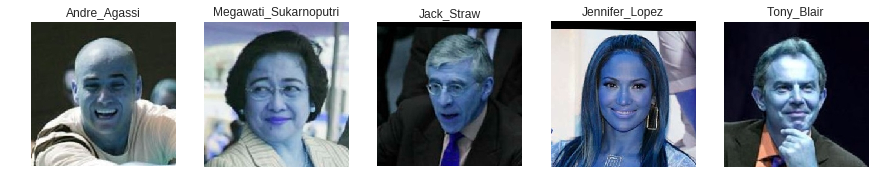

In [12]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [0]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    """Your implementation"""
    def load_videos_split(split):
      def load_video(path):
        full_path = os.path.join(dir_name, split, 'videos', path)
        filenames = os.listdir(full_path)
        return np.stack([cv2.imread(os.path.join(full_path, filename)) for filename in filenames])
      
      y_series = pd.read_csv(os.path.join(dir_name, split, 'y_{}.csv'.format(split)))
      image_dict = {path: load_video(str(path)) for (_, (path, name)) in y_series.iterrows()}
      names_dict = {path: name for (_, (path, name)) in y_series.iterrows()}
      return image_dict, names_dict
    return load_images_split(dir_name, 'train'), load_videos_split('test')

In [14]:
!head Face_Recognition_data/video_classification/train/y_train.csv

filename,class_id
0.jpg,Gene_Robinson
1.jpg,Geoff_Hoon
10.jpg,Cameron_Diaz
100.jpg,Yoriko_Kawaguchi
101.jpg,Condoleezza_Rice
102.jpg,Victoria_Clarke
103.jpg,Christine_Todd_Whitman
104.jpg,Alejandro_Toledo
105.jpg,Cameron_Diaz


In [15]:
!ls Face_Recognition_data/video_classification/test/videos/0

0.jpg	 112.jpg  12.jpg  25.jpg  38.jpg  50.jpg  63.jpg  76.jpg  89.jpg
100.jpg  113.jpg  13.jpg  26.jpg  39.jpg  51.jpg  64.jpg  77.jpg  8.jpg
101.jpg  114.jpg  14.jpg  27.jpg  3.jpg   52.jpg  65.jpg  78.jpg  90.jpg
102.jpg  115.jpg  15.jpg  28.jpg  40.jpg  53.jpg  66.jpg  79.jpg  91.jpg
103.jpg  116.jpg  16.jpg  29.jpg  41.jpg  54.jpg  67.jpg  7.jpg   92.jpg
104.jpg  117.jpg  17.jpg  2.jpg   42.jpg  55.jpg  68.jpg  80.jpg  93.jpg
105.jpg  118.jpg  18.jpg  30.jpg  43.jpg  56.jpg  69.jpg  81.jpg  94.jpg
106.jpg  119.jpg  19.jpg  31.jpg  44.jpg  57.jpg  6.jpg   82.jpg  95.jpg
107.jpg  11.jpg   1.jpg   32.jpg  45.jpg  58.jpg  70.jpg  83.jpg  96.jpg
108.jpg  120.jpg  20.jpg  33.jpg  46.jpg  59.jpg  71.jpg  84.jpg  97.jpg
109.jpg  121.jpg  21.jpg  34.jpg  47.jpg  5.jpg   72.jpg  85.jpg  98.jpg
10.jpg	 122.jpg  22.jpg  35.jpg  48.jpg  60.jpg  73.jpg  86.jpg  99.jpg
110.jpg  123.jpg  23.jpg  36.jpg  49.jpg  61.jpg  74.jpg  87.jpg  9.jpg
111.jpg  124.jpg  24.jpg  37.jpg  4.jpg   62.jpg  75.jpg

In [16]:
(video_train, train_labels), (video_test, test_labels) = load_video_data()
print '%d'%len(video_train), '\ttraining images'
print '%d'%len(video_test), '\ttesting videos'

729 	training images
70 	testing videos


In [17]:
!ls Face_Recognition_data/video_classification/test 

videos	y_test.csv


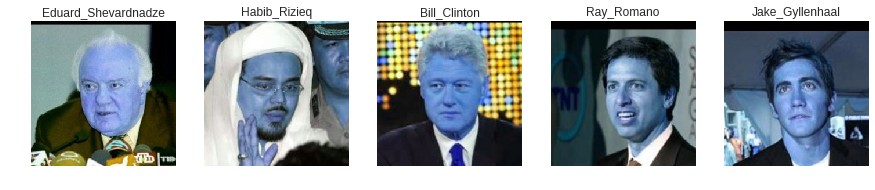

In [18]:
visualize(video_train, train_labels)

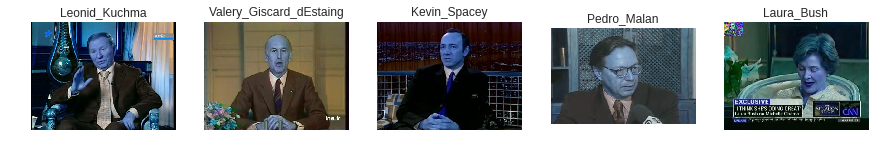

In [19]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [0]:
def preprocess_imgs(imgs):
    """Your implementation"""
    pass

#### Visualization of preprocessing

In [0]:
#visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [22]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [0]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [24]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print out.shape

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [0]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


def make_feature_extractor(model, n_drop_layers=1):
  for __ in range(n_drop_layers):
    model.pop()
  return model


def add_intermediate_layers(model):
  for l in model.layers: 
    l.trainable=False
  
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  return model


def add_classifier_layers(model, n_classes):
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
  
class Classifier():
    
    def __init__(self, nn_model):
        """Your implementation"""
        base_model = make_feature_extractor(nn_model)
        self.model = add_intermediate_layers(base_model)
        
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()


    def fit(self, train_imgs, train_labels, eval_set=None, epochs=10, batch_size=32):
        """Your implementation"""
        label_strings = np.array(list(train_labels.values()))
        labels = self.le.fit_transform(label_strings).reshape(-1, 1)
        y = self.ohe.fit_transform(labels)

        if eval_set is not None:
          eval_imgs, eval_labels = eval_set
          X_eval = self._get_image_arrays(eval_imgs)
          eval_label_strings = np.array(list(eval_labels.values()))
          eval_labels = self.le.transform(eval_label_strings).reshape(-1, 1)
          y_eval = self.ohe.transform(eval_labels)
          eval_set = (X_eval, y_eval)
          
        X = self._get_image_arrays(train_imgs)
        
        self.model = add_classifier_layers(self.model, y.shape[1])
        
        self.model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_data=eval_set)

    def classify_images(self, test_imgs):
        """Your implementation"""
        predictions = self.model.predict(self._get_image_arrays(test_imgs), batch_size=16)
        prediction_label_strings = self.decode_predictions(predictions)
        return {k: label for (k, label) in zip(test_imgs.keys(), prediction_label_strings)}
        
    def classify_videos(self, test_video):
        """Your implementation"""
        stacked_videos = self._prepare_video_array(test_video)
        video_predictions = [self.model.predict(video, batch_size=16) for video in stacked_videos]
        video_aggregated_predictions = [video_pred.mean(axis=0) for video_pred in video_predictions]
        prediction_label_strings = self.decode_predictions(video_aggregated_predictions)
        return {k: label for (k, label) in zip(test_video.keys(), prediction_label_strings)}
    
    @classmethod
    def _get_image_arrays(cls, img_dict):
      return cls._prepare_array(img_dict.values())
    
    @classmethod
    def _prepare_array(cls, imgs):
      return (np.stack([cv2.resize(img, (224, 224)) for img in imgs]) / 122.5) - 1
    
    @classmethod
    def _prepare_video_array(cls, video_dict):
      return (cls._prepare_array(video) for video in video_dict.values())
    
    def decode_predictions(self, predictions):
      prediction_labels = np.argmax(predictions, axis=1)
      return self.le.inverse_transform(prediction_labels)

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [0]:
img_classifier = Classifier(model)


In [27]:
img_classifier.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

In [28]:
len(x_test), len(y_test)

(808, 808)

In [29]:
img_classifier.fit(x_train, y_train, eval_set=(x_test, y_test), epochs=50, batch_size=8)

Train on 661 samples, validate on 808 samples
Epoch 1/50
661/661 [==============================] - 27s 40ms/step - loss: 5.3398 - acc: 0.0136 - val_loss: 4.2794 - val_acc: 0.0755
Epoch 2/50
661/661 [==============================] - 24s 36ms/step - loss: 4.4325 - acc: 0.0711 - val_loss: 3.6977 - val_acc: 0.2710
Epoch 3/50
661/661 [==============================] - 24s 36ms/step - loss: 3.7907 - acc: 0.1377 - val_loss: 3.2034 - val_acc: 0.4530
Epoch 4/50
661/661 [==============================] - 24s 36ms/step - loss: 3.3593 - acc: 0.2451 - val_loss: 2.8068 - val_acc: 0.5928
Epoch 5/50
661/661 [==============================] - 24s 36ms/step - loss: 2.9078 - acc: 0.3555 - val_loss: 2.4579 - val_acc: 0.6782
Epoch 6/50
661/661 [==============================] - 24s 36ms/step - loss: 2.5456 - acc: 0.4281 - val_loss: 2.1592 - val_acc: 0.7203
Epoch 7/50
661/661 [==============================] - 24s 36ms/step - loss: 2.1984 - acc: 0.5280 - val_loss: 1.8938 - val_acc: 0.7673
Epoch 8/50
661/6

In [30]:
y_out = img_classifier.classify_images(x_test)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [0]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [32]:
print(check_test(y_out, y_test))

Classification accuracy is 0.9035


### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [0]:
model = load_model('face_recognition_model.h5')
video_classifier = Classifier(model)

In [34]:
video_classifier.fit(video_train, train_labels, epochs=20, batch_size=16)
y_video_out = video_classifier.classify_videos(video_test)

Epoch 1/20
729/729 [==============================] - 10s 14ms/step - loss: 5.3115 - acc: 0.0123
Epoch 2/20
729/729 [==============================] - 8s 11ms/step - loss: 4.4982 - acc: 0.0494
Epoch 3/20
729/729 [==============================] - 8s 11ms/step - loss: 3.7892 - acc: 0.1303
Epoch 4/20
729/729 [==============================] - 8s 11ms/step - loss: 3.3938 - acc: 0.2305
Epoch 5/20
729/729 [==============================] - 8s 11ms/step - loss: 2.9255 - acc: 0.3100
Epoch 6/20
729/729 [==============================] - 8s 11ms/step - loss: 2.5328 - acc: 0.4362
Epoch 7/20
729/729 [==============================] - 8s 11ms/step - loss: 2.2196 - acc: 0.5075
Epoch 8/20
729/729 [==============================] - 8s 11ms/step - loss: 2.0356 - acc: 0.5405
Epoch 9/20
729/729 [==============================] - 8s 11ms/step - loss: 1.8005 - acc: 0.6036
Epoch 10/20
729/729 [==============================] - 8s 11ms/step - loss: 1.5984 - acc: 0.6626
Epoch 11/20
729/729 [=================

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
print(check_test(y_video_out, test_labels))

Classification accuracy is 0.0714
